Classify handwritten digits with k-NN
---

Exercise - Load data set
--

> **Exercise**: Load the data from the `mnist-6k.npz` file into X/y arrays. The data type of the input matrix `X` should be `float64`. Split it into train (5,000 images) and test (1,000) sets using the `train_test_split()` function. Set the `random_state` to zero. 

In [26]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

with np.load(os.path.join('data','mnist-6k.npz'), allow_pickle=False, ) as npz_file:
    mnist=dict(npz_file.items())

    
print('Content of the NPZ file:', mnist.keys())
    
X=mnist['data'].astype('float')
y=mnist['labels']

X_tr, X_te, y_tr,y_te=train_test_split(X, y, test_size=1000/len(y), random_state=0)

print("Shape of X_tr: {}".format(X_tr.shape))
print("Shape of y_tr: {}".format(y_tr.shape))
print("Shape of X_te: {}".format(X_te.shape))
print("Shape of y_te: {}".format(y_te.shape))


Content of the NPZ file: dict_keys(['data', 'labels'])
Shape of X_tr: (5000, 784)
Shape of y_tr: (5000,)
Shape of X_te: (1000, 784)
Shape of y_te: (1000,)


Exercise: Data exploration
---

> **Exercise**: What are the different categories? What is the proportion of images in each one?

In [89]:
import pandas as pd

df_categories=pd.DataFrame(y, columns=['category'])

df_categories['count']=1
df_proportion=df_categories.groupby('category').sum()
df_proportion['percentage']=df_proportion['count']/len(y)
df_proportion.sort_values('percentage', ascending=False)

,count,percentage
category,,
1,671,0.111833
7,651,0.108500
4,623,0.103833
3,608,0.101333
6,608,0.101333
9,601,0.100167
0,592,0.098667
2,581,0.096833
8,551,0.091833


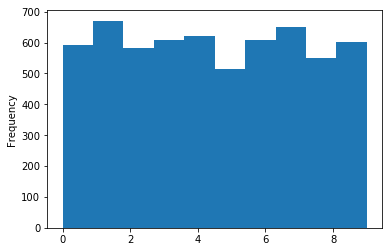

In [44]:
df_categories[''].plot.hist(bins=10)
plt.show()

> **Exercise**: Plot some images with their labels from the X/y arrays.

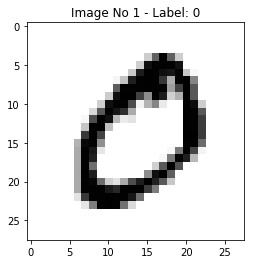

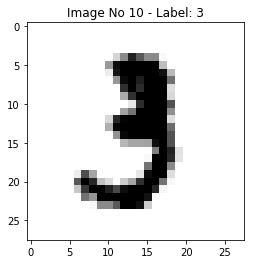

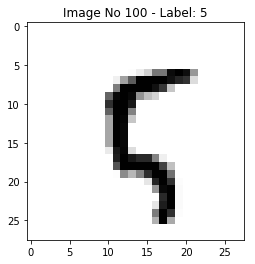

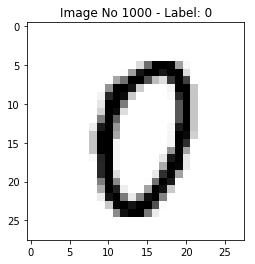

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot image 1, 10, 100 and 1000

for i in [1, 10, 100, 1000]:
    plt.imshow(X[i].reshape(28,28), cmap=plt.cm.gray_r)
    plt.title("Image No {} - Label: {}".format(i, y[i]))
    plt.show()
    

Exercise: Set a baseline
---

> **Exercise**: Create a baseline model using the `DummyClassifier` object from Scikit-learn and evaluate its performance on the test set.

In [90]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Fit it
dummy.fit(X_tr, y_tr)

# Compute test accuracy
accuracy = dummy.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))


Accuracy: 0.105


Exercise: Create k-NN classifier
---

> **Exercise**: Build a k-NN classifier using a `Pipeline` object (set k to 5). Try with and without standardization.

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

knn_pipe=Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, algorithm='brute'))
])

knn_pipe.fit(X_tr, y_tr)
print('Test accuracy with standardization: {:.3f}'.format(knn_pipe.score(X_te, y_te)))

knn_pipe2 = clone(knn_pipe)
knn_pipe2.set_params(scaler=None)
knn_pipe2.fit(X_tr, y_tr)
print('Test accuracy without standardization: {:.3f}'.format(knn_pipe2.score(X_te, y_te)))

Test accuracy with standardization: 0.899
Test accuracy without standardization: 0.941


Exercise: Tune k using grid search
---

> **Exercise**: Tune k using grid search. Plot the test accuracy.

**Hint**: You don't have to compute the train accuracy which is computationally expensive due to the size of the train set.

In [94]:
import numpy as np

# Generate a set of k values
k_values = np.arange(1, 20, 1)
k_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [105]:
# Variable to store the results
gs_results = []

knn_pipe=Pipeline([('knn',KNeighborsClassifier(n_neighbors=5, algorithm='brute'))])

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_tr/255, y_tr)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'k': k,
        'test_accuracy': knn_pipe.score(X_te/255, y_te),
        'train_accuracy': knn_pipe.score(X_tr/255, y_tr)
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by='test_accuracy', ascending=False).head(5)

,k,test_accuracy,train_accuracy
0,1,0.952,1.0000
2,3,0.951,0.9704
3,4,0.949,0.9642
8,9,0.944,0.9478
10,11,0.943,0.9418


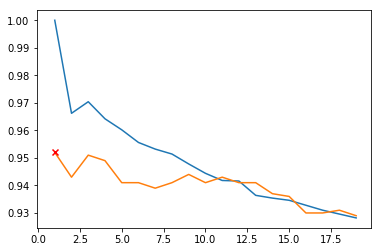

In [106]:
plt.plot(k_values, gs_results['train_accuracy'], label='Train accuracy')
plt.plot(k_values, gs_results['test_accuracy'], label='Test accuracy')

best_k=1                     
plt.scatter(best_k, gs_results['test_accuracy'].max(), marker='x', c='red', zorder=10)